<a href="https://colab.research.google.com/github/adbreind/accelerate-rapids/blob/master/01_RAPIDS_cuDF_cuML_cuGraph.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Environment Sanity Check #

Click the _Runtime_ dropdown at the top of the page, then _Change Runtime Type_ and confirm the instance type is _GPU_.

Check the output of `!nvidia-smi` to make sure you've been allocated a Tesla T4.

In [1]:
!nvidia-smi

Wed Oct  9 15:23:18 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 418.56       Driver Version: 418.56       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GeForce GTX 1060    Off  | 00000000:01:00.0 Off |                  N/A |
| N/A   49C    P2    30W /  N/A |    661MiB /  6078MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [2]:
# intall miniconda
!wget -c https://repo.continuum.io/miniconda/Miniconda3-4.5.4-Linux-x86_64.sh
!chmod +x Miniconda3-4.5.4-Linux-x86_64.sh
!bash ./Miniconda3-4.5.4-Linux-x86_64.sh -b -f -p /usr/local

# install RAPIDS packages
!conda install -q -y --prefix /usr/local -c nvidia -c rapidsai \
  -c numba -c conda-forge -c pytorch -c defaults \
  cudf=0.9 cuml=0.9 cugraph=0.9 python=3.6 cudatoolkit=10.0

# set environment vars
import sys, os, shutil
sys.path.append('/usr/local/lib/python3.6/site-packages/')
os.environ['NUMBAPRO_NVVM'] = '/usr/local/cuda/nvvm/lib64/libnvvm.so'
os.environ['NUMBAPRO_LIBDEVICE'] = '/usr/local/cuda/nvvm/libdevice/'

# copy .so files to current working dir
for fn in ['libcudf.so', 'librmm.so']:
  shutil.copy('/usr/local/lib/'+fn, os.getcwd())

--2019-09-30 22:13:02--  https://repo.continuum.io/miniconda/Miniconda3-4.5.4-Linux-x86_64.sh
Resolving repo.continuum.io (repo.continuum.io)... 104.18.201.79, 104.18.200.79, 2606:4700::6812:c84f, ...
Connecting to repo.continuum.io (repo.continuum.io)|104.18.201.79|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 58468498 (56M) [application/x-sh]
Saving to: ‘Miniconda3-4.5.4-Linux-x86_64.sh’

Miniconda3-4.5.4-Li 100%[===================>]  55.76M  61.4MB/s    in 0.9s    

2019-09-30 22:13:03 (61.4 MB/s) - ‘Miniconda3-4.5.4-Linux-x86_64.sh’ saved [58468498/58468498]

PREFIX=/usr/local
installing: python-3.6.5-hc3d631a_2 ...
Python 3.6.5 :: Anaconda, Inc.
installing: ca-certificates-2018.03.07-0 ...
installing: conda-env-2.6.0-h36134e3_1 ...
installing: libgcc-ng-7.2.0-hdf63c60_3 ...
installing: libstdcxx-ng-7.2.0-hdf63c60_3 ...
installing: libffi-3.2.1-hd88cf55_4 ...
installing: ncurses-6.1-hf484d3e_0 ...
installing: openssl-1.0.2o-h20670df_0 ...
installing: tk

# cuDF and cuML Smoke Test 

_Note_: You must import nvstrings and nvcategory before cudf, else you'll get errors.

In [2]:
import nvstrings, nvcategory, cudf

gdf = cudf.DataFrame({'test':[1,2,3]})
print(gdf)
print(gdf.describe())

   test
0     1
1     2
2     3
       test
count   3.0
mean    2.0
std     1.0
min     1.0
25%     1.5
50%     2.0
75%     2.5
max     3.0


In [3]:
import cuml

df_float = cudf.DataFrame()
df_float['0'] = [1.0, 2.0, 5.0]
df_float['1'] = [4.0, 2.0, 1.0]

dbscan_float = cuml.DBSCAN(eps=1.0, min_samples=1)
dbscan_float.fit(df_float)

print(dbscan_float.labels_)

0    0
1    1
2    2
dtype: int32


In [4]:
import cugraph

G = cugraph.Graph()
G.add_edge_list(cudf.Series([0, 1, 2, 2], dtype='int32'),
                cudf.Series([1, 2, 0, 3], dtype='int32'))
cugraph.strongly_connected_components(G)

,labels,vertices
0,0,0
1,0,1
2,0,2
3,3,3


In [5]:
print("INSTALL SUCCESS")

INSTALL SUCCESS


In [5]:
print 'stopping here on purpose' # post-install

SyntaxError: Missing parentheses in call to 'print'. Did you mean print('stopping here on purpose' # post-install)? (<ipython-input-5-f82bf4183d56>, line 1)

# Add GPU to Pandas-Style Analytics with cuDF

## Beer Review Data Analysis

In this lab, we'll practice using Pandas by exploring a dataset of beer reviews. 

First we'll retrieve a small slice of the data. The full beer review dataset is surprisingly large ... or maybe not that surprising, since it seems like the kind of job that would be hard to give up so long as one more beer was out there :)

First we'll import Pandas and retrieve the data:

In [2]:
import cudf

df = cudf.read_csv('data/beer_small.csv')

df

,Unnamed: 0,brewery_id,brewery_name,review_time,review_overall,review_aroma,review_appearance,review_profilename,beer_style,review_palate,review_taste,beer_name,beer_abv,beer_beerid
0,784200,952,Great Dane Pub & Brewing Company (Downtown),1136269921,4.5,4.0,4.0,dirtylou,American IPA,4.0,4.0,Texas Speedbump IPA,null,11846
1,1305265,29,Anheuser-Busch,1234830966,4.5,4.0,3.0,talkinghatrack,Light Lager,3.0,4.0,Bud Light Lime,4.2,41821
2,1526298,45,Brooklyn Brewery,1078599557,4.5,4.0,4.0,PopeJonPaul,Scotch Ale / Wee Heavy,4.0,4.5,Brooklyn Heavy Scotch Ale,7.5,16355
3,450647,590,New Glarus Brewing Company,1288790879,4.5,4.5,4.5,sweemzander,American Wild Ale,4.5,4.0,R&D Bourbon Barrel Kriek,5.5,60588
4,1223094,4,Allagash Brewing Company,1295320417,4.5,4.5,4.0,Jmoore50,American Wild Ale,4.0,4.0,Allagash Victor Francenstein,9.7,56665
5,609060,493,Cosmos Brewery (Thai Beverage Plc.),1322578304,3.0,3.0,2.5,krazyboi,American Adjunct Lager,2.5,3.0,Chang Beer (Export),5.0,39875
6,324853,447,Pabst Brewing Company,1193696641,4.0,2.0,3.0,CortexBomb,American Adjunct Lager,3.0,4.0,Pabst Blue Ribbon (PBR),4.74,1331
7,924200,75,Grupo Modelo S.A. de C.V.,1277714791,4.0,2.5,3.0,DovaliHops,Munich Dunkel Lager,3.0,3.0,Negra Modelo,5.4,667
8,34961,1199,Founders Brewing Company,1271918658,4.5,4.5,3.5,Destral,American Double / Imperial Stout,4.0,5.0,Founders KBS (Kentucky Breakfast Stout),11.2,19960
9,426580,666,Emerson's Brewery,1192461083,5.0,4.0,4.5,Lukie,English India Pale Ale (IPA),4.0,5.0,1812 India Pale Ale,4.7,4594


How many reviews are there?

In [3]:
len(df)

158661

How can we tell if there are missing values?

In [4]:
df.count()

Unnamed: 0            158661
brewery_id            158661
brewery_name          158660
review_time           158661
review_overall        158661
review_aroma          158661
review_appearance     158661
review_profilename    158627
beer_style            158661
review_palate         158661
review_taste          158661
beer_name             158661
beer_abv              151790
beer_beerid           158661
dtype: int64

Since most reviews have data for most fields, let's drop the records with incomplete data

In [5]:
df2 = df.dropna()

In [6]:
df2.count()

Unnamed: 0            151755
brewery_id            151755
brewery_name          151755
review_time           151755
review_overall        151755
review_aroma          151755
review_appearance     151755
review_profilename    151755
beer_style            151755
review_palate         151755
review_taste          151755
beer_name             151755
beer_abv              151755
beer_beerid           151755
dtype: int64

Let's get summary statistics for the numeric columns ... things like review score and ABV

In [7]:
df2.describe()

,Unnamed: 0,brewery_id,review_time,review_overall,review_aroma,review_appearance,review_palate,review_taste,beer_abv,beer_beerid
count,1.517550e+05,151755.000000,1.517550e+05,151755.000000,151755.000000,151755.000000,151755.00000,151755.000000,151755.000000,151755.000000
mean,7.931438e+05,3076.986860,1.225230e+09,3.826312,3.747498,3.851099,3.75810,3.805987,7.040849,21395.262192
std,4.579958e+05,5550.476844,7.586247e+07,0.715491,0.693592,0.612823,0.67664,0.727087,2.309585,21775.199244
min,2.000000e+01,1.000000,8.846496e+08,1.000000,1.000000,1.000000,1.00000,1.000000,0.050000,5.000000
25%,3.970765e+05,141.000000,1.175567e+09,3.500000,3.500000,3.500000,3.50000,3.500000,5.200000,1658.000000
50%,7.916940e+05,415.000000,1.240346e+09,4.000000,4.000000,4.000000,4.00000,4.000000,6.500000,12846.000000
75%,1.187644e+06,2298.000000,1.288995e+09,4.500000,4.000000,4.000000,4.00000,4.500000,8.500000,39263.500000
max,1.586594e+06,27934.000000,1.326268e+09,5.000000,5.000000,5.000000,5.00000,5.000000,57.700000,77315.000000


There are some really low-alcohol beers in there ... maybe even bogus data.

Find all entries with ABV less than 1%

In [8]:
low_abv = df2[df2.beer_abv < 1]

low_abv

,Unnamed: 0,brewery_id,brewery_name,review_time,review_overall,review_aroma,review_appearance,review_profilename,beer_style,review_palate,review_taste,beer_name,beer_abv,beer_beerid
2920,1279683,224,St. Pauli Brauerei C.L. Wilh. Brandt Gmbh & Co.,1288020769,1.0,2.0,3.0,Arithmeticus,Low Alcohol Beer,4.0,1.0,St. Pauli N. A.,0.50,826
4681,325151,447,Pabst Brewing Company,1263519646,2.0,1.5,1.5,roddwolff,Low Alcohol Beer,1.5,2.0,Old Milwaukee Non Alcoholic,0.40,5719
7009,1312241,29,Anheuser-Busch,1188051103,3.0,1.5,1.5,pmcadamis,Low Alcohol Beer,2.0,2.0,O'Doul's,0.50,5727
8186,330754,306,Coors Brewing Company,1194633882,5.0,5.0,4.5,ncshots,Low Alcohol Beer,5.0,5.0,Coors Non-Alcoholic,0.50,8588
8483,584061,360,Warsteiner Brauerei,1049053396,2.5,2.5,2.5,Pegasus,Low Alcohol Beer,2.5,2.5,Warsteiner Premium Fresh,0.50,2140
9828,1279681,224,St. Pauli Brauerei C.L. Wilh. Brandt Gmbh & Co.,1298860529,3.0,2.5,3.0,mikesgroove,Low Alcohol Beer,3.0,3.0,St. Pauli N. A.,0.50,826
10565,1494545,613,Bitburger Brauerei,1166019385,2.0,3.0,2.5,MTNboy,Low Alcohol Beer,3.5,2.5,Bitburger Drive,0.50,5415
10703,1312152,29,Anheuser-Busch,1054645269,1.5,2.0,2.5,bditty187,Low Alcohol Beer,3.0,2.0,O'Doul's,0.50,5727
11789,1312209,29,Anheuser-Busch,1254680184,2.5,2.0,3.0,Thorpe429,Low Alcohol Beer,2.5,2.0,O'Doul's,0.50,5727
16496,1279702,224,St. Pauli Brauerei C.L. Wilh. Brandt Gmbh & Co.,1235193279,4.5,4.5,4.5,ZAP,Low Alcohol Beer,4.5,4.5,St. Pauli N. A.,0.50,826


How many of these reviews are there?

In [9]:
len(low_abv)

96

Some of these are multiple reviews for the same beer, which is allowed (and even encouraged). Let's group by beer and count.

In [10]:
grouping = low_abv.groupby('beer_name')
grouping.size()

beer_name
Beck's Alkoholfrei                 4
Bitburger Drive                    3
Busch NA                           3
Carlsberg Non-Alcoholic            2
Clausthaler Golden Amber           7
Clausthaler Premium                6
Coors Non-Alcoholic                2
Erdinger Weissbier Alkoholfrei     2
Faxe Free                          1
Kaiser                             1
Kaliber                            9
Kvas                               1
Labatt Nordic / .5                 1
Malta Guinness                     1
Nanny State                        2
O'Doul's                          15
O'Doul's Amber                     6
Old Milwaukee Non Alcoholic        3
President's Choice Red Brew        1
Prostel Alkoholfrei                1
Sharp's                            5
Sol Cero                           1
Störtebeker Frei-Bier              1
St. Pauli N. A.                   10
Stella Artois NA                   1
Warsteiner Premium Fresh           6
Xtra Malt                   

How consistent are the O'Douls overall scores?

In [11]:
scores = low_abv[low_abv.beer_name=="O'Doul's"]['review_overall']
scores

7009      3.0
10703     1.5
11789     2.5
38343     2.5
48237     3.0
49202     2.0
49321     1.5
55432     3.0
71283     2.0
75362     1.5
86890     3.5
94585     1.0
97625     3.0
99892     3.0
145997    3.0
Name: review_overall, dtype: float64

Let's plot a histogram

In [12]:
scores.hist()

AttributeError: 'Series' object has no attribute 'hist'

# conv > pandas FIXME

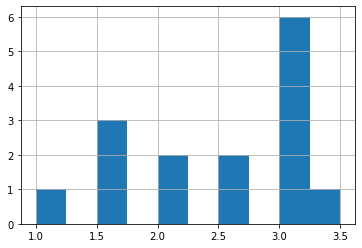

In [14]:
scores.to_pandas().hist()

What are the mean and sd for the O'Doul's overall scores?

In [15]:
scores.mean(), scores.std()

(2.4, 0.7606388292556653)

In the full dataset, can we count beers by brewery, and then by style within that brewery?

In [16]:
df2.groupby(['brewery_name', 'beer_style']).size()

brewery_name                     beer_style                         
Žatecký Pivovar                 Czech Pilsener                          8
                                 Euro Dark Lager                         4
À La Fût                         Tripel                                  1
                                 Witbier                                 1
À l’abri de la Tempête           American Barleywine                     2
                                 American Blonde Ale                     1
                                 American IPA                            1
                                 American Pale Lager                     1
                                 Scotch Ale / Wee Heavy                  7
Ängö Kvartersbryggeri            Dubbel                                  1
                                 Munich Dunkel Lager                     1
Åbro Bryggeri                    Dortmunder / Export Lager               1
                               

### Now we'll try and build up a slightly more complex report

Step 1: Find all rows corresponsing to reviews where the beer style starts with "American"

In [17]:
all_american = df2[df2.beer_style.str.startswith('American')]
all_american

,Unnamed: 0,brewery_id,brewery_name,review_time,review_overall,review_aroma,review_appearance,review_profilename,beer_style,review_palate,review_taste,beer_name,beer_abv,beer_beerid
3,450647,590,New Glarus Brewing Company,1288790879,4.5,4.5,4.5,sweemzander,American Wild Ale,4.5,4.0,R&D Bourbon Barrel Kriek,5.50,60588
4,1223094,4,Allagash Brewing Company,1295320417,4.5,4.5,4.0,Jmoore50,American Wild Ale,4.0,4.0,Allagash Victor Francenstein,9.70,56665
5,609060,493,Cosmos Brewery (Thai Beverage Plc.),1322578304,3.0,3.0,2.5,krazyboi,American Adjunct Lager,2.5,3.0,Chang Beer (Export),5.00,39875
6,324853,447,Pabst Brewing Company,1193696641,4.0,2.0,3.0,CortexBomb,American Adjunct Lager,3.0,4.0,Pabst Blue Ribbon (PBR),4.74,1331
8,34961,1199,Founders Brewing Company,1271918658,4.5,4.5,3.5,Destral,American Double / Imperial Stout,4.0,5.0,Founders KBS (Kentucky Breakfast Stout),11.20,19960
10,1250129,1480,Matilda Bay Brewing Co.,1159680113,4.0,4.5,4.0,vancurly,American Pale Ale (APA),4.0,4.0,Alpha Pale Ale,5.20,26053
19,151027,3818,Southern Tier Brewing Company,1204153289,4.0,4.5,4.0,WillieMoe,American Barleywine,4.0,4.0,Backburner (Imperial Barley Wine Style Ale),9.60,36185
24,728901,17963,Nectar Ales,1312873910,3.5,4.0,3.5,Sensaray,American IPA,3.5,3.5,IPA Nectar,6.80,9024
26,745463,12877,NINE G Brewing Company,1189556274,4.0,4.5,4.0,Phatz,American Double / Imperial IPA,4.0,4.5,Infidel Imperial IPA,8.40,31041
28,94239,140,Sierra Nevada Brewing Co.,1269655771,4.0,4.5,4.5,CaptainIPA,American IPA,4.5,4.5,Sierra Nevada Torpedo Extra IPA,7.20,30420


Next, make a dataframe with just the `beer_style` and `review_overall` fields for those rows.

In [18]:
narrowed = all_american[['beer_style', 'review_overall']]
narrowed

,beer_style,review_overall
3,American Wild Ale,4.5
4,American Wild Ale,4.5
5,American Adjunct Lager,3.0
6,American Adjunct Lager,4.0
8,American Double / Imperial Stout,4.5
10,American Pale Ale (APA),4.0
19,American Barleywine,4.0
24,American IPA,3.5
26,American Double / Imperial IPA,4.0
28,American IPA,4.0


Now we'll make a boxplot to capture the range and variance of the ratings. Pandas will do all the work is we call the built-in API. Look for it here: https://pandas.pydata.org/pandas-docs/stable/user_guide/visualization.html

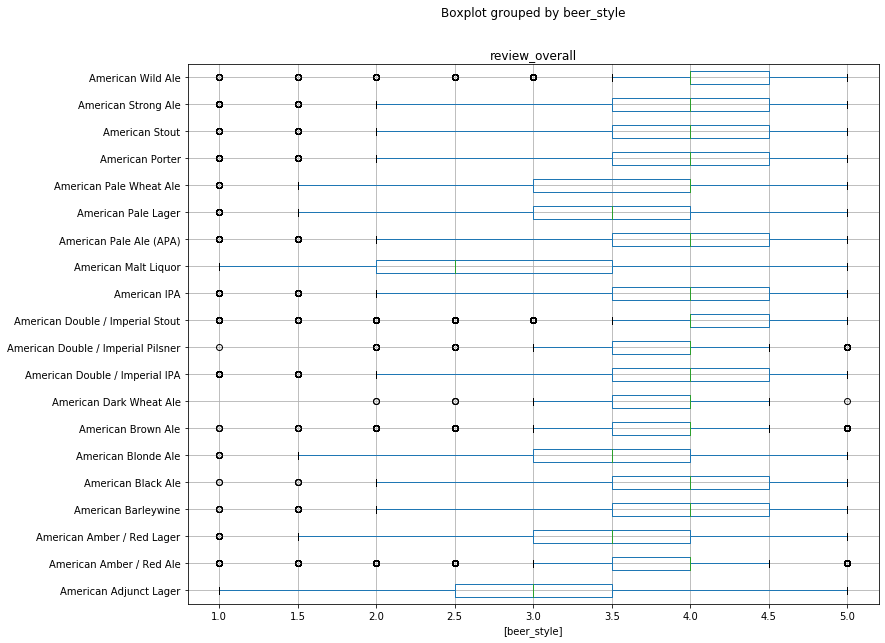

In [19]:
narrowed.to_pandas().boxplot(by='beer_style', vert=False, figsize=(12,10))

# Add GPU to Scikit-Learn-Style Modeling with cuML

## Dataset: Diamonds

This dataset of diamond sales (http://ggplot2.tidyverse.org/reference/diamonds.html) is of moderate size (~55,000 records) and resembles data records that occur in many business scenarios.

For each of the diamond sales records, we have the following properties:
* price: price in US dollars ($326-$18,823)
* carat: weight of the diamond (0.2-5.01)
* cut: quality of the cut (Fair, Good, Very Good, Premium, Ideal)
* color: diamond colour, from J (worst) to D (best)
* clarity: a measurement of how clear the diamond is (I1 (worst), SI2, SI1, VS2, VS1, VVS2, VVS1, IF (best))
* x: length in mm (0-10.74)
* y: width in mm (0-58.9)
* z: depth in mm (0-31.8)
* depth: total depth percentage = z / mean(x, y) = 2 * z / (x + y) (43-79)
* table: width of top of diamond relative to widest point (43-95)

In [1]:
import cudf 

df = cudf.read_csv('data/diamonds.csv')

df.head(5)

,Unnamed: 0,carat,cut,color,clarity,depth,table,price,x,y,z
0,1,0.23,Ideal,E,SI2,61.5,55.0,326,3.95,3.98,2.43
1,2,0.21,Premium,E,SI1,59.8,61.0,326,3.89,3.84,2.31
2,3,0.23,Good,E,VS1,56.9,65.0,327,4.05,4.07,2.31
3,4,0.29,Premium,I,VS2,62.4,58.0,334,4.20,4.23,2.63
4,5,0.31,Good,J,SI2,63.3,58.0,335,4.34,4.35,2.75


The "unnamed" column is a row number in the dataset. It turns out that this row number -- which sounds like it should be meaningless -- actually leaks key data about the diamonds. 

Can you think of why this might be?

In [2]:
df.iloc[:,1]

0        0.23
1        0.21
2        0.23
3        0.29
4        0.31
5        0.24
6        0.24
7        0.26
8        0.22
9        0.23
10       0.30
11       0.23
12       0.22
13       0.31
14       0.20
15       0.32
16       0.30
17       0.30
18       0.30
19       0.30
20       0.30
21       0.23
22       0.23
23       0.31
24       0.31
25       0.23
26       0.24
27       0.30
28       0.23
29       0.23
         ... 
53910    0.70
53911    0.57
53912    0.61
53913    0.80
53914    0.84
53915    0.77
53916    0.74
53917    0.90
53918    0.76
53919    0.76
53920    0.70
53921    0.70
53922    0.70
53923    0.73
53924    0.73
53925    0.79
53926    0.71
53927    0.79
53928    0.79
53929    0.71
53930    0.71
53931    0.71
53932    0.70
53933    0.70
53934    0.72
53935    0.72
53936    0.72
53937    0.70
53938    0.86
53939    0.75
Name: carat, Length: 53940, dtype: float64

In [3]:
df['price']

0         326
1         326
2         327
3         334
4         335
5         336
6         336
7         337
8         337
9         338
10        339
11        340
12        342
13        344
14        345
15        345
16        348
17        351
18        351
19        351
20        351
21        352
22        353
23        353
24        353
25        354
26        355
27        357
28        357
29        357
         ... 
53910    2753
53911    2753
53912    2753
53913    2753
53914    2753
53915    2753
53916    2753
53917    2753
53918    2753
53919    2753
53920    2755
53921    2755
53922    2755
53923    2756
53924    2756
53925    2756
53926    2756
53927    2756
53928    2756
53929    2756
53930    2756
53931    2756
53932    2757
53933    2757
53934    2757
53935    2757
53936    2757
53937    2757
53938    2757
53939    2757
Name: price, Length: 53940, dtype: int64

In [4]:
smaller_df = df.sample(frac=0.05)

AttributeError: 'DataFrame' object has no attribute 'sample'

In [6]:
import torch

random_vals = torch.rand(len(df), device='cuda:0')

cudf.Series(random_vals)

0        0.657548
1        0.382304
2        0.291642
3        0.451533
4        0.245293
5        0.618340
6        0.371166
7        0.198570
8        0.189920
9        0.302995
10       0.834333
11       0.351927
12       0.176763
13       0.237318
14       0.114784
15       0.647723
16       0.458974
17       0.494136
18       0.809107
19       0.201054
20       0.515402
21       0.641503
22       0.054771
23       0.145066
24       0.918726
25       0.692297
26       0.785004
27       0.378315
28       0.165126
29       0.192686
           ...   
53910    0.230074
53911    0.234529
53912    0.162280
53913    0.039837
53914    0.369788
53915    0.770810
53916    0.992344
53917    0.491876
53918    0.781569
53919    0.714220
53920    0.558844
53921    0.690972
53922    0.890618
53923    0.794050
53924    0.157284
53925    0.944553
53926    0.608000
53927    0.040926
53928    0.330812
53929    0.833354
53930    0.658093
53931    0.459206
53932    0.945140
53933    0.820621
53934    0

In [7]:
mask = cudf.Series(random_vals)

In [8]:
sample = df[mask < 0.0002]
sample

,Unnamed: 0,carat,cut,color,clarity,depth,table,price,x,y,z
7107,7108,0.92,Premium,D,SI2,62.4,58.0,4168,6.18,6.19,3.86
17425,17426,1.08,Premium,G,VS1,62.7,56.0,6982,6.55,6.52,4.10
21029,21030,1.03,Ideal,G,VVS2,61.6,56.0,9236,6.48,6.50,4.00
36480,36481,0.43,Very Good,G,VS1,60.9,57.0,943,4.88,4.91,2.98
36735,36736,0.32,Very Good,E,VVS1,60.8,58.0,954,4.38,4.41,2.67
36842,36843,0.37,Premium,F,VS2,59.7,59.0,957,4.68,4.64,2.78
40221,40222,0.40,Premium,D,VS1,62.1,58.0,1123,4.70,4.73,2.93


In [9]:
sample.columns

Index(['Unnamed: 0', 'carat', 'cut', 'color', 'clarity', 'depth', 'table',
       'price', 'x', 'y', 'z'],
      dtype='object')

In [10]:
records = df[['Unnamed: 0', 'price']][mask < 0.05].to_pandas().astype('float32')

In [11]:
records.plot.scatter('Unnamed: 0', 'price', s=0.05, figsize=(10,8))

Let's get rid of the row number:

In [12]:
df2 = df.drop(df.columns[0], axis=1)

df2[:3]

,carat,cut,color,clarity,depth,table,price,x,y,z
0,0.23,Ideal,E,SI2,61.5,55.0,326,3.95,3.98,2.43
1,0.21,Premium,E,SI1,59.8,61.0,326,3.89,3.84,2.31
2,0.23,Good,E,VS1,56.9,65.0,327,4.05,4.07,2.31


#### Categorical Feautres

Now ... computers are good with numbers, but what about those words? ("Premium", "Ideal", etc.)

It turns out that not only do we need to convert them to numbers, but we often want to do that in a way that treats them as totally separate properties.

That is, we consider the "Ideal"-ness of a diamond totally separately from the "Premium"-ness of that diamond, etc., and of course each diamond only has one of those properties. This is called "one-hot encoding" (or sometimes "dummy variable encoding" or "one of k encoding").

Why do we do this? Wouldn't it make more sense to measure the goodness-of-cut along a numeric scale, almost like the carat weight?

In theory, yes -- and in some case your team may want to do that. But without putting in a lot of work (or having the business domain knowledge) to get that right, we can approximate with this encoding that is, in essence, just a math trick.

In [13]:
df2.cut.value_counts()

Ideal        21551
Premium      13791
Very Good    12082
Good          4906
Fair          1610
Name: cut, dtype: int32

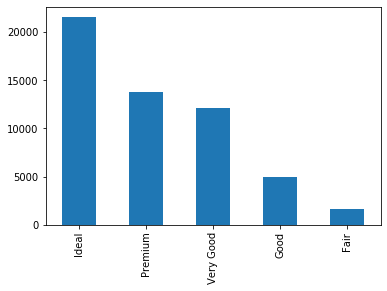

In [14]:
df2.cut.value_counts().to_pandas().plot(kind='bar')

In [15]:
df2.dtypes

carat      float64
cut         object
color       object
clarity     object
depth      float64
table      float64
price        int64
x          float64
y          float64
z          float64
dtype: object

In [16]:
df3 = cudf.get_dummies(df2)

df3.iloc[:3, 7:18]

,cut_Fair,cut_Good,cut_Ideal,cut_Premium,cut_Very Good,color_D,color_E,color_F,color_G,color_H,color_I
0,0,0,1,0,0,0,1,0,0,0,0
1,0,0,0,1,0,0,1,0,0,0,0
2,0,1,0,0,0,0,1,0,0,0,0


Now we'll split out a "test set" -- remember we want to be able to evaluate the model on records that it hasn't seen before.

In [17]:
from cuml.preprocessing.model_selection import train_test_split

y = df3.price.to_frame() ###

df3.drop_column('price') ## API DIFFERENCE
X = df3

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7) ## API DIFFERENCE

#### Baselines

In this case we'll use the mean price of the diamonds as a (constant) baseline model:

In [18]:
y.mean()

price    3932.799722
dtype: float64

So our first "baseline" model just says for any diamond we might look at, its price is about $3900. Obviously this is usually going to be wrong, and often by a lot. But it's better than nother. Later we'll see how to compare a "real" model against this one.

Next, we'll set up the model. As we said above, kNN is very simple ... but even complex models are easy to set up with this code library:

slearn:

```python
from sklearn.neighbors import KNeighborsRegressor

neigh = KNeighborsRegressor(n_neighbors=5)
model = neigh.fit(X_train, y_train) 
```

In [19]:
from cuml.neighbors import NearestNeighbors

nn_float = NearestNeighbors()
nn_float.fit(X_train)

NearestNeighbors(n_neighbors=5, n_gpus=1, devices=None, verbose=False, handle=<cuml.common.handle.Handle object at 0x7fe43d87d1f8>)

In [20]:
# get nearest neighbors - test
distances,indices = nn_float.kneighbors(X_test[:10],k=3)

print(indices)
print(distances)

       0      1      2
0  21684  23987  23341
1  23149   7848  30260
2   8099  29288  36329
3  16916  20469  36959
4   1662  11596  29012
5  36670   6733  11810
6  13437   9369   2155
7  12071  14180    816
8   3370  20694  19416
9  13676  20892  11354
          0         1         2
0  0.008301  0.016113  0.017578
1  0.001465  0.057617  0.060547
2  0.000977  0.004883  0.017578
3  0.005859  0.040527  0.053711
4  0.499023  0.551758  0.613281
5  0.632812  0.753418  1.996582
6  0.353516  0.396484  0.499023
7  0.022949  0.041504  0.045898
8  0.010742  0.011230  0.012207
9  0.144531  0.342773  0.494141


In [24]:
indices.columns

Index(['0', '1', '2'], dtype='object')

In [34]:
distances,indices = nn_float.kneighbors(X_test,k=3)

nearest_prices = cudf.DataFrame()
nearest_prices['0'] = y_train.iloc[indices[str(0)], :].price
nearest_prices['1'] = y_train.iloc[indices[str(1)], :].price
nearest_prices['2'] = y_train.iloc[indices[str(2)], :].price

nearest_prices

,0,1,2
21684,1026,629,706
23149,971,1323,1263
8099,5922,5967,6589
16916,758,871,898
1662,1267,1601,811
36670,2445,5195,5586
13437,6267,5731,2700
12071,2762,2309,2469
3370,489,461,628
13676,4028,3162,2348


In [48]:
nearest_prices.mean(axis=1)

AssertionError: 

In [59]:
y_pred = (nearest_prices['0'] + nearest_prices['1'] + nearest_prices['2'])/3.0

Ok, how did we do?

For regression problems like this, we'll measure the accuracy of our predictions using RMSE (root mean squared error). This is a measure of "how wrong" we typically are in our predictions, measured in the units we are predicting (i.e., in this case, dollars).

In [141]:
pred = y_pred.reset_index()[0]
ground_truth = y_test.reset_index().price

np.sqrt(((ground_truth - pred)**2).mean())

985.5239634210326

So is that actually any good?

One way to get an idea is to compare it to the standard deviation of the data:

In [80]:
y_test.std()

price    4007.064337
dtype: float64

# Yeah!

## Build a Parametric Model: Linear Regression

The canonical example of a parametric model is a linear regression model. Linear regression -- which you might have done by hand on a small amount of data in high school or a college stats class -- is simple, fast, robust, and performs reasonably well for many kinds of real-world data.

In fact, linear regression is one of the two or three most widely used algorithms in the world for data modeling.

Here's a simple version with one predictor and one response plotted against each other, along with a regression line:

<img src="https://materials.s3.amazonaws.com/i/gyP3KGA.png">

How does the computer (or the student) figure out where to draw that regression line? The goal is to minimize the __error__.

What is the error? The difference (or distance) between the true value and the value predicted by the regression line:

<img src="https://materials.s3.amazonaws.com/i/cgvGCMg.jpg" width=600>

That might be getting into too much detail for this class, so let's just say we want to calculate the mathematically best-fit line.

You can also notice that if the data itself does not embody a linear relationship, this approach may not work very well. Surprisingly, a lot of phenomena do have a large enough linear component that this algorithm often works. One thing that will help it fit complex data -- like your business records or our diamond sales -- is using more dimensions. That is, unlike the pictures here which just have one predictor (to make the pictures simple), we can use the same approach to calculate a response as a linear function of many dimensions. 

Let's fit a linear regression model to our diamonds dataset:

```python
from sklearn import linear_model

lr = linear_model.LinearRegression()
linear = lr.fit(X_train, y_train)

y_pred = linear.predict(X_test)
print("RMSE %f" % np.sqrt(mean_squared_error(y_test, y_pred)) )
```

In [115]:
from cuml import linear_model

lr = linear_model.LinearRegression()

reg = lr.fit(X_train, y_train)

In [116]:
def to_float32(df): #not just numeric, but 32-bit is (currently) critical for predictors and response
    for col in df.columns:
        new_col = df[col].astype('float32')
        df.drop_column(col)
        df[col] = new_col
    
to_float32(X_train)

In [117]:
reg = lr.fit(X_train, y_train.price.astype('float32'))

print("Coefficients:")
print(reg.coef_)
print("Intercept:")
print(reg.intercept_)

Coefficients:
0     11267.382812
1       -60.068100
2       -25.389545
3     -1980.498413
4      1005.793945
5       -91.808540
6     -1733.457153
7     -1172.491211
8      -922.903381
9      -943.249634
10    -1030.335693
11     -340.282043
12     -544.576538
13     -616.968628
14     -822.102783
15    -1309.279053
16    -1768.406982
17    -2754.415039
18    -5216.122559
19      103.799019
20    -1553.794800
21    -2506.464355
22     -651.237000
23     -960.227173
24     -230.776031
25     -283.358521
dtype: float32
Intercept:
9192.775390625


In [118]:
to_float32(X_test)
preds = lr.predict(X_test)

print("Predictions:")
print(preds)

Predictions:
0         950.158203
1        1819.503906
2        6175.995117
3         980.834961
4        1800.060547
5        3869.677734
6        5101.191406
7        2525.051758
8        -201.269531
9        3938.347168
10       5335.297852
11       -174.734375
12       1371.030273
13       1944.279785
14       4574.399902
15        980.269531
16       1649.818848
17       6727.963867
18        635.810547
19       2418.758301
20       2390.042480
21        198.234375
22       2673.738770
23        545.544922
24       2525.128418
25       8139.437500
26       4589.000488
27       -215.369141
28         66.093750
29       6371.263672
            ...     
16152    2300.716797
16153    7105.974121
16154    5723.021484
16155    1297.320801
16156    6824.818359
16157    8283.551758
16158     881.943359
16159     520.466797
16160    6610.753906
16161    2891.828613
16162     782.149414
16163     586.067383
16164    1547.493652
16165     696.866211
16166    4581.422852
16167    2563.127930


This model didn't fit quite as well as the kNN model (the RMSE here is larger, indicating our predictions are off by a few hundred more dollars). However, this model is very compact, since it is completely defined by about 27 parameters:

In [142]:
np.sqrt(((y_test.reset_index().price - preds)**2).mean())

1219.8125886430946

And making a prediction requires just multiplying and then adding 26 pairs of numbers, so it is lightning fast, even on the tiniest embedded IoT device. Alternatively, if we want to make billions of predictions, we could do that in a second with higher-end server.

### Lab: Powerplant Output 

https://archive.ics.uci.edu/ml/datasets/combined+cycle+power+plant

About the business problem: peaker plant operation

What is in this dataset? Just under 10,000 observations of:

* Temperature (AT) in the range 1.81°C and 37.11°C
* Ambient Pressure (AP) in the range 992.89-1033.30 millibar,
* Relative Humidity (RH) in the range 25.56% to 100.16%
* Exhaust Vacuum (V) in the range 25.36-81.56 cm Hg
* Net hourly electrical energy output (PE) 420.26-495.76 MW

What is the goal? To model output (PE) based other measurements

In [146]:
df = cudf.read_csv('data/powerplant.csv')

df

,AT,V,AP,RH,PE
0,14.96,41.76,1024.07,73.17,463.26
1,25.18,62.96,1020.04,59.08,444.37
2,5.11,39.40,1012.16,92.14,488.56
3,20.86,57.32,1010.24,76.64,446.48
4,10.82,37.50,1009.23,96.62,473.90
5,26.27,59.44,1012.23,58.77,443.67
6,15.89,43.96,1014.02,75.24,467.35
7,9.48,44.71,1019.12,66.43,478.42
8,14.64,45.00,1021.78,41.25,475.98
9,11.74,43.56,1015.14,70.72,477.50


First, think about your intuition, experience, or "domain knowledge" that might apply -- even if you don't know about power generation, you may have some ideas about atmospheric pressure and temperature, and how they might affect a combustion-based power output.

Test those ideas by building some plots. With just 4 predictors, you can make plots with all of them. Notice anything interesting?

Try to build a linear regression model for power output. (Hint: you can cut/paste a lot of the code we've already used in this notebook!)